In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
from pyspark.sql.functions import round
from pyspark.sql import Window
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.functions import log
from pyspark.sql.functions import regexp_replace
import scipy.stats as st
import pandas as pd
from operator import add
from functools import reduce
import geopandas as gpd
import folium
from shapely.wkt import loads 
import matplotlib.pyplot as plt  
import seaborn as sns

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [44]:
final = spark.read.parquet('../data/curated/merchant_info.parquet')
top_100 = spark.read.parquet('../data/curated/top_100.parquet')
art_combine = spark.read.parquet('../data/curated/art_combine.parquet')
sports_combine = spark.read.parquet('../data/curated/sports_combine.parquet')
technology_combine = spark.read.parquet('../data/curated/technology_combine.parquet')
home_combine = spark.read.parquet('../data/curated/home_combine.parquet')
health_combine = spark.read.parquet('../data/curated/health_combine.parquet')

In [167]:
top_100_pd = top_100.limit(10).toPandas()
art_combine_pd = art_combine.limit(10).toPandas()
sports_combine_pd = sports_combine.limit(10).toPandas()
technology_combine_pd = technology_combine.limit(10).toPandas()
home_combine_pd = home_combine.limit(10).toPandas()
health_combine_pd = health_combine.limit(10).toPandas()

In [194]:
df_10 = top_100[['Avg_count_monthly','Avg_amount_monthly']].toPandas().iloc[:10].reset_index().rename(columns = {'index' : 'rank_10', 'Avg_count_monthly' : 'count_10', 'Avg_amount_monthly':'amount_10'}).reset_index()
df_100 = top_100[['Avg_count_monthly','Avg_amount_monthly']].toPandas().iloc[90:100].reset_index().rename(columns = {'index' : 'rank_100', 'Avg_count_monthly' : 'count_100', 'Avg_amount_monthly':'amount_100'}).reset_index()

In [198]:
df_top = [df_10,df_100]
df_merge_top = reduce(lambda left,right: pd.merge(left,right, on = ['index', 'index']), df_top).drop(columns = {'index' : 'rank'}).reset_index()

In [199]:
df_merge_top

,index,rank_10,count_10,amount_10,rank_100,count_100,amount_100
0,0,0,100.000000,81.505597,90,5.402230,46.038526
1,1,1,96.613201,64.862775,91,1.591762,71.632711
2,2,2,64.564611,44.804967,92,5.345078,8.660408
3,3,3,76.942128,43.841566,93,6.498193,10.193235
4,4,4,34.781939,86.663118,94,10.253856,6.249942
5,5,5,59.952291,48.793955,95,5.900376,14.101222
6,6,6,67.528017,71.948377,96,2.729484,7.609660
7,7,7,43.538735,95.805357,97,5.162993,10.921828
8,8,8,11.765481,71.667246,98,0.807580,71.373813
9,9,9,0.271816,59.731080,99,7.580351,48.481497


Text(0.5, 1.0, 'The monthly count for the first 10 merchant and the last 10 merchant in the top 100 merchant')

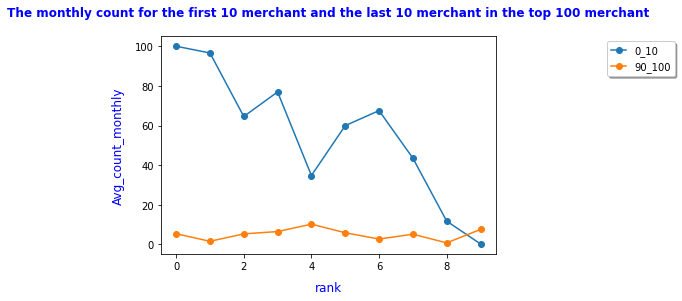

In [201]:
df_merge_top.plot.line(x = 'index', y = ['count_10', 'count_100'], marker='o')
plt.legend(['0_10', '90_100'], loc='upper right', bbox_to_anchor=(1.55, 1), shadow=True, handlelength=1.5, fontsize=10)

plt.ylabel('Avg_count_monthly', labelpad = 10, color = 'blue', fontsize=12)
plt.xlabel('rank', labelpad = 10, color = 'blue', fontsize=12)
plt.title('The monthly count for the first 10 merchant and the last 10 merchant in the top 100 merchant', pad = 20, color = 'blue', weight = 'bold')

Text(0.5, 1.0, 'The monthly amount for the first 10 merchant and the last 10 merchant in the top 100 merchant')

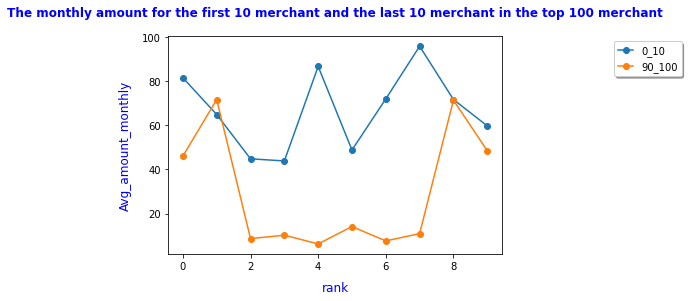

In [202]:
df_merge_top.plot.line(x = 'index', y = ['amount_10', 'amount_100'], marker='o')
plt.legend(['0_10', '90_100'], loc='upper right', bbox_to_anchor=(1.55, 1), shadow=True, handlelength=1.5, fontsize=10)

plt.ylabel('Avg_amount_monthly', labelpad = 10, color = 'blue', fontsize=12)
plt.xlabel('rank', labelpad = 10, color = 'blue', fontsize=12)
plt.title('The monthly amount for the first 10 merchant and the last 10 merchant in the top 100 merchant', pad = 20, color = 'blue', weight = 'bold')

In [160]:
art_combine_df = art_combine_pd[['Avg_amount_monthly','Avg_count_monthly']].reset_index().rename(columns = {'Avg_amount_monthly' : 'art_combine_amount', 'Avg_count_monthly' : 'art_combine_count'})
sports_combine_df = sports_combine_pd[['Avg_amount_monthly','Avg_count_monthly']].reset_index().rename(columns = {'Avg_amount_monthly' : 'sports_combine_amount', 'Avg_count_monthly' : 'sports_combine_count'})
technology_combine_df = technology_combine_pd[['Avg_amount_monthly','Avg_count_monthly']].reset_index().rename(columns = {'Avg_amount_monthly' : 'technology_combine_amount', 'Avg_count_monthly' : 'technology_combine_count'})
home_combine_df = home_combine_pd[['Avg_amount_monthly','Avg_count_monthly']].reset_index().rename(columns = {'Avg_amount_monthly' : 'home_combine_amount', 'Avg_count_monthly' : 'home_combine_count'})
health_combine_df = health_combine_pd[['Avg_amount_monthly','Avg_count_monthly']].reset_index().rename(columns = {'Avg_amount_monthly' : 'health_combine_amount', 'Avg_count_monthly' : 'health_combine_count'})

In [161]:
df = [art_combine_df,sports_combine_df,technology_combine_df,home_combine_df,health_combine_df ]
df_merge = reduce(lambda left,right: pd.merge(left,right, on = ['index', 'index']), df).rename(columns = {'index' : 'rank'})

Text(0.5, 1.0, 'The average value of monthly amount in different tags of merchant')

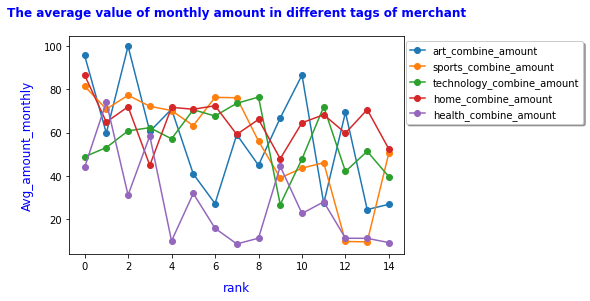

In [162]:
df_merge.plot.line(x = 'rank', y = ['art_combine_amount', 'sports_combine_amount', 'technology_combine_amount', 'home_combine_amount', 'health_combine_amount'], marker='o')
plt.legend(['art_combine_amount', 'sports_combine_amount', 'technology_combine_amount', 'home_combine_amount', 'health_combine_amount'], loc='upper right', bbox_to_anchor=(1.55, 1), shadow=True, handlelength=1.5, fontsize=10)

plt.ylabel('Avg_amount_monthly', labelpad = 10, color = 'blue', fontsize=12)
plt.xlabel('rank', labelpad = 10, color = 'blue', fontsize=12)
plt.title('The average value of monthly amount in different tags of merchant', pad = 20, color = 'blue', weight = 'bold')

Text(0.5, 1.0, 'The average value of monthly count in different tags of merchant')

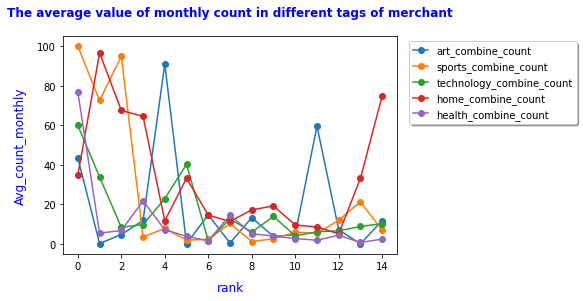

In [163]:
df_merge.plot.line(x = 'rank', y = ['art_combine_count', 'sports_combine_count', 'technology_combine_count', 'home_combine_count', 'health_combine_count'], marker='o')
plt.legend(['art_combine_count', 'sports_combine_count', 'technology_combine_count', 'home_combine_count', 'health_combine_count'], loc='upper right', bbox_to_anchor=(1.55, 1), shadow=True, handlelength=1.5, fontsize=10)

plt.ylabel('Avg_count_monthly', labelpad = 10, color = 'blue', fontsize=12)
plt.xlabel('rank', labelpad = 10, color = 'blue', fontsize=12)
plt.title('The average value of monthly count in different tags of merchant', pad = 20, color = 'blue', weight = 'bold')

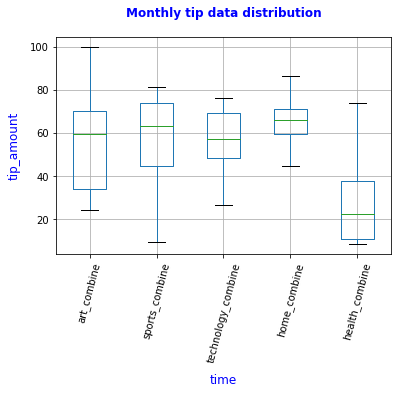

In [164]:
#
art_combine_pd_amount = art_combine_pd['Avg_amount_monthly']
sports_combine_pd_amount = sports_combine_pd['Avg_amount_monthly']
technology_combine_pd_amount = technology_combine_pd['Avg_amount_monthly']
home_combine_pd_amount = home_combine_pd['Avg_amount_monthly']
health_combine_pd_amount = health_combine_pd['Avg_amount_monthly']

data = pd.DataFrame({"art_combine": art_combine_pd_amount, "sports_combine": sports_combine_pd_amount, "technology_combine": technology_combine_pd_amount, 
                    "home_combine": home_combine_pd_amount, "health_combine": health_combine_pd_amount}) 

#Draw the box plot and set the labels and title of the plot
data.boxplot()  
plt.xticks(rotation=75)
plt.ylabel("tip_amount", labelpad = 10, color = 'blue', fontsize=12) 
plt.xlabel("tag group", labelpad = 10, color = 'blue', fontsize=12)
plt.title('average anount monthly in different tags group',pad = 20, color = 'blue', weight = 'bold')
plt.show() 

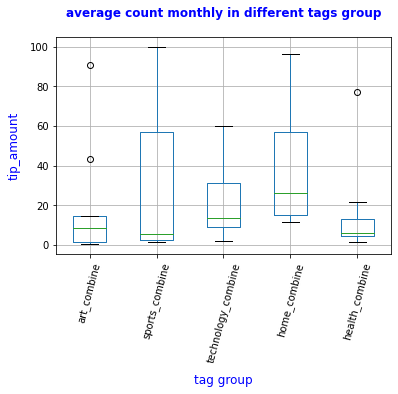

In [203]:
#
art_combine_pd_count = art_combine_pd['Avg_count_monthly']
sports_combine_pd_count = sports_combine_pd['Avg_count_monthly']
technology_combine_pd_count = technology_combine_pd['Avg_count_monthly']
home_combine_pd_count = home_combine_pd['Avg_count_monthly']
health_combine_pd_count = health_combine_pd['Avg_count_monthly']

data = pd.DataFrame({"art_combine": art_combine_pd_count, "sports_combine": sports_combine_pd_count, "technology_combine": technology_combine_pd_count, 
                    "home_combine": home_combine_pd_count, "health_combine": health_combine_pd_count}) 

#Draw the box plot and set the labels and title of the plot
data.boxplot()  
plt.xticks(rotation=75)
plt.ylabel("tip_amount", labelpad = 10, color = 'blue', fontsize=12) 
plt.xlabel("tag group", labelpad = 10, color = 'blue', fontsize=12)
plt.title('average count monthly in different tags group',pad = 20, color = 'blue', weight = 'bold')
plt.show() 

Text(0.5, 1.0, 'The number of different store type in top 100 merchant ')

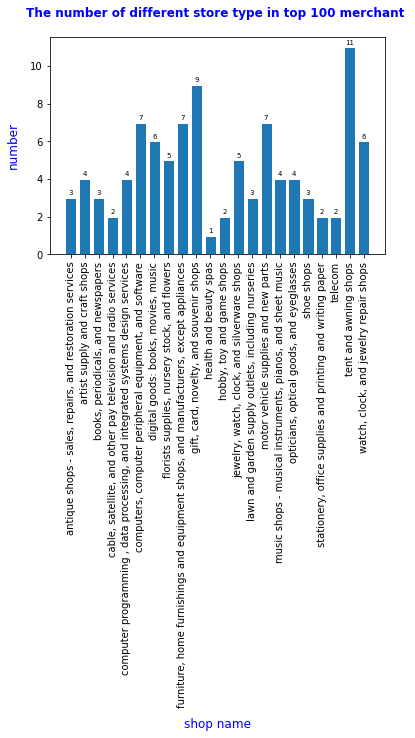

In [28]:
# store type with top 100
tz_df = top_100_pd[['Store_type','Revenue_levels']].groupby(['Store_type']).count()

fig, ax = plt.subplots()

y = tz_df['Revenue_levels']

bars = ax.bar(
    x = range(1,23),
    height = y, edgecolor='white',
    tick_label = tz_df.index, width = 0.8
)

plt.xticks(rotation=90)
ax.bar_label(bars, padding=2, color = 'black', fontsize=7)
ax.xaxis.grid(False)

ax.set_ylabel('number', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('shop name', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The number of different store type in top 100 merchant ', pad = 20, color = 'blue', weight = 'bold')
#plt.savefig('../plots/store_type_large_count.png', bbox_inches='tight')

In [46]:
post_final = final.select('postcode', 'merchant_abn')

In [47]:
top_100_1 = top_100.join(post_final, top_100.merchant_abn == post_final.merchant_abn).drop(top_100.merchant_abn)

In [60]:
geospark = spark.read.parquet('../data/curated/postcode_SA2.parquet/')
conrrespondences = spark.read.parquet('../data/curated/postcode_sa2_conrrespondences.parquet')
census = spark.read.parquet('../data/curated/final_census.parquet')
geospark_geometry = spark.read.parquet('../data/curated/SA2_2021_VIC_shapefile.parquet/')


#vic_data = geospark.join(census, geospark.SA2_CODE21 == census.SA2_CODE_2021, "left").drop(census.SA2_CODE_2021)

In [67]:
new_geospark_geometry = geospark_geometry.join(conrrespondences, geospark_geometry.SA2_CODE21 == conrrespondences.SA2_CODE_2021).drop(conrrespondences.SA2_CODE_2021)

In [71]:
new_geospark_geometry = new_geospark_geometry.select('postcode', 'SA2_CODE21', 'geometry')

In [72]:
new_geospark_geometry.count()

1407

In [52]:
top_100_2 = top_100_1.select('postcode','merchant_abn')

In [73]:
top_100_2.count()

100

In [76]:
vic_data_new = top_100_2.join(new_geospark_geometry, top_100_2.postcode == new_geospark_geometry.postcode).drop(new_geospark_geometry.postcode)
#vic_data = vic_data_new.groupBy('postcode','merchant_abn').agg(F.avg('avg_lat').alias('avg_lat'),F.avg('avg_long').alias('avg_long'))
vic_data_new

postcode,merchant_abn,SA2_CODE21,geometry
3238,90918180829,217031476,MULTIPOLYGON (((1...
3265,21359184622,217031474,POLYGON ((143.092...
3265,21359184622,217031475,MULTIPOLYGON (((1...
3265,21359184622,217041477,POLYGON ((142.414...
3724,67978471888,204011057,POLYGON ((146.031...
3378,76819856970,215011387,POLYGON ((142.426...
3415,78760357380,215011390,POLYGON ((140.965...
3415,52959528548,215011390,POLYGON ((140.965...
3415,49891706470,215011390,POLYGON ((140.965...
3415,49505931725,215011390,POLYGON ((140.965...
